#M4_Notebook_Bob Ross Paintings

Team ID: B1 Team 3

Name: Irene (Yihui) Tang

**Question:**

Do Bob Ross paintings form a small number of interpretable palette archetypes based on binary paint usage?

**Method:**
- Clustering
- Association Rules

**M4 focus on:**
- linking clusters to metadata and title themes to check whether rare clusters align with season, episode, or theme.
- comparing linkage methods and rule parameters for rigor.
- comparing palette clusters to title-based clusters to see if text and palette structure align.

##0.Load and Explore the Dataset

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances

from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [92]:
bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [93]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##1.Data Overview

In [94]:
print(f"Dataset size: {bob_ross.shape}")
print("\nColumn types:")

display(bob_ross.head())

Dataset size: (403, 27)

Column types:


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [95]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

In [96]:
# Check for missing values
print("Missing values check:")
missing = bob_ross.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  No missing values found")

# Check for duplicates
print(f"\nDuplicate paintings: {bob_ross.duplicated().sum()}")

Missing values check:
  No missing values found

Duplicate paintings: 0


##2.EDA

###2.1 Identify paint cols

In [97]:
paint_cols = bob_ross.select_dtypes(include=["bool"]).columns.tolist()

print("Number of paint columns:", len(paint_cols))
print("Paint columns:", paint_cols)

Number of paint columns: 18
Paint columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']


I encode each painting as a binary “palette” over the 18 paints. With this setup, I can cluster paintings to define palette archetypes and then use association rules to summarize stable co-usage patterns inside each archetype. Each row is a painting. Now, each column is a paint (0/1).

###2.2 Paint Count Summary

In [98]:
X = bob_ross[paint_cols].astype(int)
bob_ross["paint_count"] = X.sum(axis=1)
display(X.describe().T[["mean", "std", "min", "max"]].sort_values("mean", ascending=False).head(10))
display(bob_ross["paint_count"].describe())

,mean,std,min,max
Titanium_White,0.992556,0.086065,0.0,1.0
Alizarin_Crimson,0.942928,0.232268,0.0,1.0
Van_Dyke_Brown,0.920596,0.270705,0.0,1.0
Cadmium_Yellow,0.858561,0.348907,0.0,1.0
Yellow_Ochre,0.811414,0.391665,0.0,1.0
Phthalo_Blue,0.801489,0.399375,0.0,1.0
Bright_Red,0.796526,0.403082,0.0,1.0
Midnight_Black,0.786600,0.410217,0.0,1.0
Sap_Green,0.759305,0.428037,0.0,1.0
Indian_Yellow,0.724566,0.447288,0.0,1.0


,paint_count
count,403.000000
mean,10.605459
std,2.378525
min,1.000000
25%,9.000000
50%,11.000000
75%,12.000000
max,15.000000


This is a simple proxy for palette complexity. Need for later to check if clusters differ in complexity.

###2.3 Paint Count Distribution

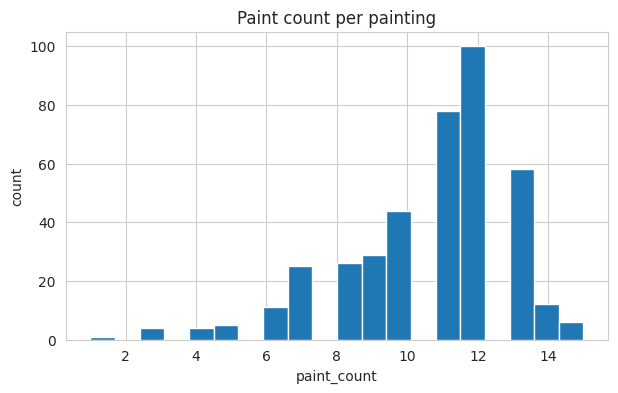

In [99]:
plt.figure(figsize=(7,4))
plt.hist(bob_ross["paint_count"], bins=20)
plt.title("Paint count per painting")
plt.xlabel("paint_count")
plt.ylabel("count")
plt.show()

If paint_count varies a lot, palette styles may differ in complexity.

###2.4 Top Paint Prevalence

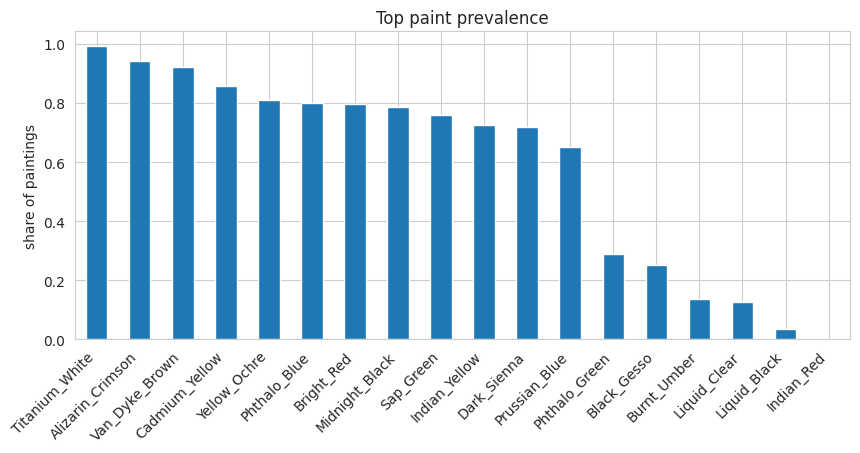

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


In [100]:
paint_prev = X.mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
paint_prev.head(20).plot(kind="bar")
plt.title("Top paint prevalence")
plt.ylabel("share of paintings")
plt.xticks(rotation=45, ha="right")
plt.show()

display(paint_prev.head(20))

A few paints appear in many paintings. For rules, lift matters because high-prevalence paints can create misleading co-occurrence.

###2.5 Structure Evidence

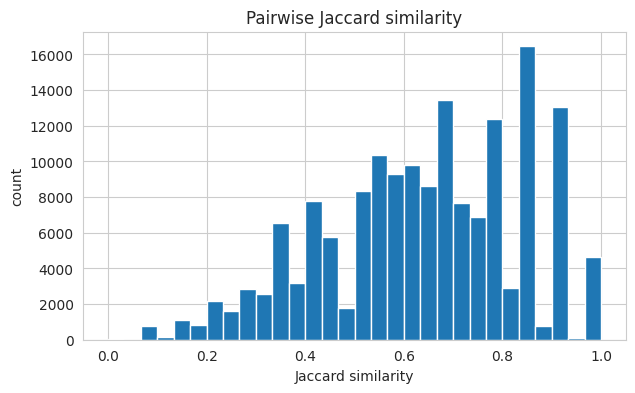

,0
count,162006.000000
mean,0.634615
std,0.200912
min,0.000000
25%,0.500000
50%,0.642857
75%,0.785714
max,1.000000


In [101]:
X_bool = X.to_numpy(dtype=bool)

D_jaccard = pairwise_distances(X_bool, metric="jaccard")
S_jaccard = 1 - D_jaccard

np.fill_diagonal(S_jaccard, np.nan)
sim_vals = S_jaccard[~np.isnan(S_jaccard)].ravel()

plt.figure(figsize=(7,4))
plt.hist(sim_vals, bins=30)
plt.title("Pairwise Jaccard similarity")
plt.xlabel("Jaccard similarity")
plt.ylabel("count")
plt.show()

display(pd.Series(sim_vals).describe())

###2.6Variable Exploration

####Summary statistics

In [102]:
# Summary Statistics
print("Summary statistics of num_colors:")
display(bob_ross["num_colors"].describe())

Summary statistics of num_colors:


,num_colors
count,403.000000
mean,10.605459
std,2.378525
min,1.000000
25%,9.000000
50%,11.000000
75%,12.000000
max,15.000000


####Distribution

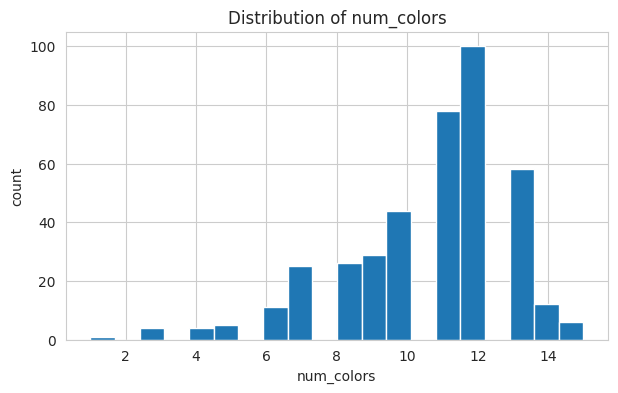

In [103]:
# Distribution of num_colors
plt.figure(figsize=(7,4))
plt.hist(bob_ross["num_colors"], bins=20)
plt.title("Distribution of num_colors")
plt.xlabel("num_colors")
plt.ylabel("count")
plt.show()

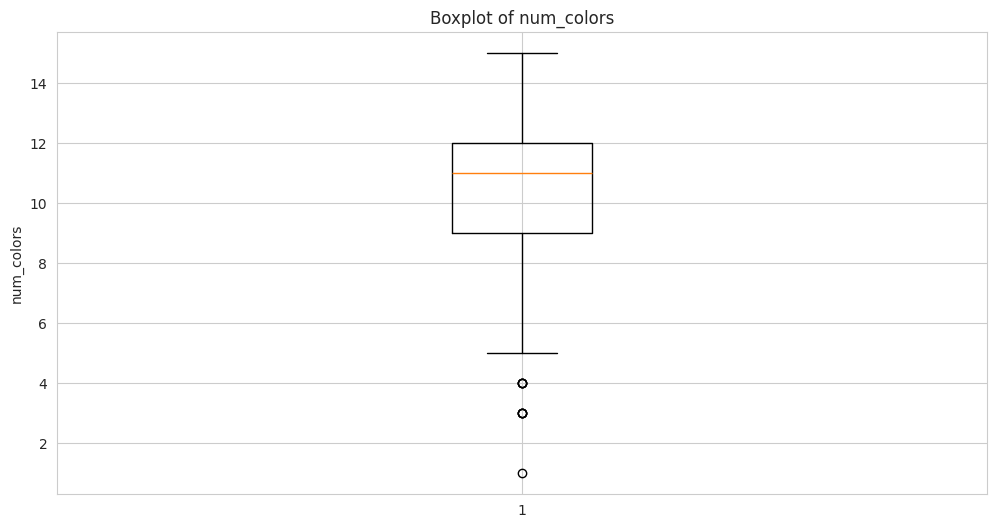

In [104]:
plt.figure()
plt.boxplot(bob_ross["num_colors"].dropna())
plt.title("Boxplot of num_colors")
plt.ylabel("num_colors")
plt.show()


The distribution of colors shows that most paintings use a moderate number of colors (9-13), indicating a consistent of visual complexity across works.

The boxplot shows that hte number of colors used in the paintings is tightly concentrated around the median, with only a few outliers.

####Extremes

In [105]:
# show extremes
min_row = bob_ross.loc[bob_ross["num_colors"].idxmin(), ["painting_title","season","episode","num_colors"]]
max_val = bob_ross["num_colors"].max()
max_rows = bob_ross.loc[bob_ross["num_colors"] == max_val, ["painting_title","season","episode","num_colors"]]

print("Min num_colors example:")
display(min_row.to_frame().T)

print("Max num_colors examples (first 10):")
display(max_rows.head(10))

Min num_colors example:


,painting_title,season,episode,num_colors
200,Contemplative Lady,16,6,1


Max num_colors examples (first 10):


,painting_title,season,episode,num_colors
214,Spectacular Waterfall,17,7,15
293,Valley Waterfall,23,8,15
306,Graceful Waterfall,24,8,15
328,Lake in the Valley,26,4,15
339,Angler's Haven,27,2,15
341,Wilderness Falls,27,4,15


Extreme cases shows that paintings with very few colors are rare, while paintings with the maximum number of colors tend to be more complex, this suggests that it captures the differences in painting style rather than random variation.

Several high number of colors paintings have related to natural secnes such as waterfalls or landscpes, suggesting that visually rich scenes may be associated with higher color usage.

###2.7.Identify Paint Indicator Columns and Imbalance

In [106]:
paint_bool_cols = bob_ross.select_dtypes(include=["bool"]).columns.tolist()
print("Number of boolean paint columns:", len(paint_bool_cols))
print("Example paint columns:", paint_bool_cols[:8])

X_paint_df = bob_ross[paint_bool_cols].astype(int)

X_paint_bool = X_paint_df.to_numpy(dtype=bool)

Number of boolean paint columns: 18
Example paint columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black']


In [107]:
exclude = {"painting_index","img_src","painting_title","season","episode","num_colors",
           "youtube_src","colors","color_hex"}

paint_like_cols = []
for c in bob_ross.columns:
    if c in exclude:
        continue
    if bob_ross[c].dtype == bool:
        paint_like_cols.append(c)
    else:
        vals = set(bob_ross[c].dropna().unique())
        if vals.issubset({0, 1}):
            paint_like_cols.append(c)

print("Number of paint-like columns:", len(paint_like_cols))

Number of paint-like columns: 18


The dataset contains 18 binary paint indicator columns, each representing whether a specific color is used in a painting.

In [108]:
X = bob_ross[paint_bool_cols].copy()

for c in paint_bool_cols:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

usage_rate = X.mean().sort_values(ascending=False)

print("Top 10 most used paints:")
display(usage_rate.head(10))

print("Bottom 10 least used paints:")
display(usage_rate.tail(10))


Top 10 most used paints:


,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


Bottom 10 least used paints:


,0
Sap_Green,0.759305
Indian_Yellow,0.724566
Dark_Sienna,0.719603
Prussian_Blue,0.652605
Phthalo_Green,0.287841
Black_Gesso,0.250620
Burnt_Umber,0.136476
Liquid_Clear,0.126551
Liquid_Black,0.034739
Indian_Red,0.002481


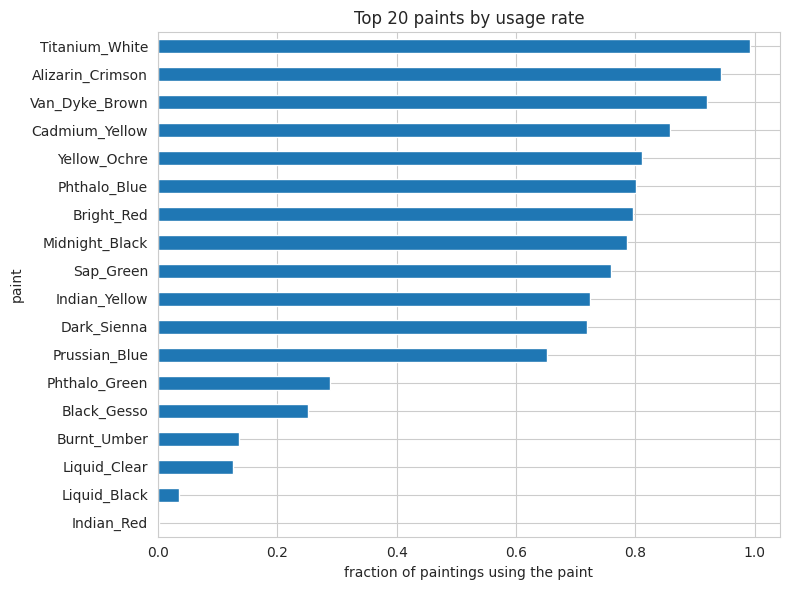

In [109]:
# Plot top 20 usage rates
topN = 20
plt.figure(figsize=(8,6))
usage_rate.head(topN).sort_values().plot(kind="barh")
plt.title(f"Top {topN} paints by usage rate")
plt.xlabel("fraction of paintings using the paint")
plt.ylabel("paint")
plt.tight_layout()
plt.show()

Paint usage is also highly imbalanced across the 18 indicators, where a small set of core paints appears in nearly all paintings, most notably Titanium White (0.9926), Alizarin Crimson (0.9429), and Van Dyke Brown (0.9206).

###2.8Text Analysis

####Text Distribution

In [110]:
bob_ross["title_len"] = bob_ross["painting_title"].str.split().apply(len)
bob_ross["title_len"].describe()

,title_len
count,403.000000
mean,2.454094
std,0.785282
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,5.000000


The painting titles are generally short, with a median length of two words and a maximum of five words. This indicates that titles tend to emphasize a small number of salient concepts rather than detailed descriptions.

In [111]:
from collections import Counter

words = (bob_ross["painting_title"].str.lower()
    .str.replace("[^a-z ]", "", regex=True)
    .str.split()
    .sum())
stopwords = {"the", "of", "a", "in", "on", "at", "and"}

words_clean = [w for w in words if w not in stopwords]
word_freq = Counter(words_clean)

In [112]:
filtered_words = pd.Series(words_clean)
filtered_words.value_counts().head(10)

,count
mountain,45
winter,37
oval,21
autumn,18
lake,16
cabin,15
sunset,13
stream,11
waterfall,11
forest,10


Frequent title words are dominated by landscape features, seasonal references, and natural scenery, suggesting a strong thematic consistency in how paintings are named.

In [113]:
keyword_groups = {
    "landscape": {"mountain", "valley", "meadow", "forest", "woods"},
    "water": {"lake", "river", "stream", "waterfall", "falls"},
    "season_time": {"winter", "autumn", "day", "sunset"},
    "objects_view": {"cabin", "barn", "view", "oval"},}

dim_counts = {
    dim: sum(w in kws for w in words_clean)
    for dim, kws in keyword_groups.items()}

pd.Series(dim_counts)

,0
landscape,79
water,54
season_time,78
objects_view,54


Aggregating title words into thematic groups reveals that landscape and seasonal references are the most prominent dimensions, followed by water-related features and specific scenic objects. This structured distribution suggests that painting titles encode recurring high-level themes rather than isolated keywords.

####Text Similarity

In [114]:
title_sets = (
    bob_ross["painting_title"]
    .str.lower()
    .str.replace(r"[^a-z ]", "", regex=True)
    .str.split()
    .apply(set))

In [115]:
n = len(title_sets)
S_text = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        A = title_sets.iloc[i]
        B = title_sets.iloc[j]
        if len(A | B) > 0:
            sim = len(A & B) / len(A | B)
        else:
            sim = 0
        S_text[i, j] = sim
        S_text[j, i] = sim

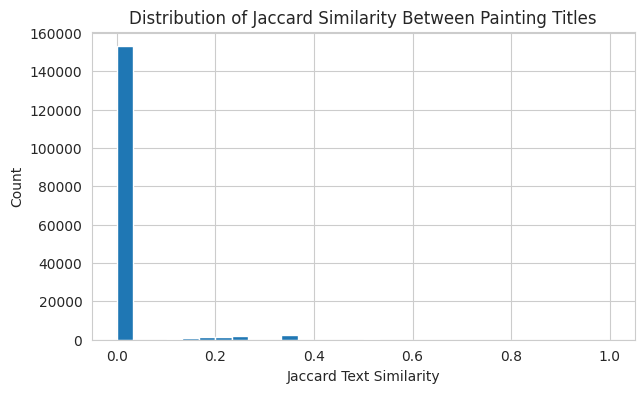

In [116]:
np.fill_diagonal(S_text, np.nan)
sim_text_vals = S_text[~np.isnan(S_text)].ravel()


plt.figure(figsize=(7,4))
plt.hist(sim_text_vals, bins=30)
plt.xlabel("Jaccard Text Similarity")
plt.ylabel("Count")
plt.title("Distribution of Jaccard Similarity Between Painting Titles")
plt.show()


Pairwise Jaccard similarity between painting titles is heavily concentrated near zero, indicating minimal lexical overlap across most title pairs. Only a small number of pairs exhibit moderate to high similarity, reflecting occasional reuse of specific words rather than pervasive redundancy.

###2.9 Similarity

####Similarity Distribution

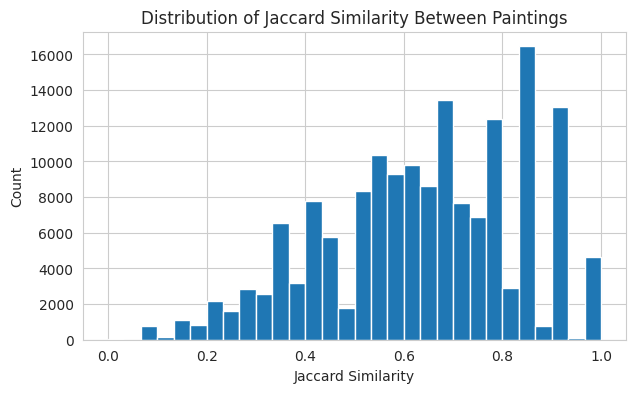

In [117]:
D = pairwise_distances(X_paint_bool, metric="jaccard")
S = 1 - D

np.fill_diagonal(S, np.nan)
sim_vals = S[~np.isnan(S)].ravel()

plt.figure(figsize=(7,4))
plt.hist(sim_vals, bins=30)
plt.title("Distribution of Jaccard Similarity Between Paintings")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count")
plt.show()

In [118]:
print("Similarity summary:")
print(pd.Series(sim_vals).describe())

Similarity summary:
count    162006.000000
mean          0.634615
std           0.200912
min           0.000000
25%           0.500000
50%           0.642857
75%           0.785714
max           1.000000
dtype: float64


The similarity distribution shows that most paintings share a moderate to high level of paint overlap, and the most common exact paint recipe appears in dozens of paintings. This pattern indicates a consistent core palette across Bob Ross's work.

This similarity structure motivate the use of clustering methods to identify goups of paintings with similar color palettes.

####Nearest Neighbors

In [119]:
meta_cols = ["painting_index", "season", "episode", "painting_title", "num_colors"]
meta_cols = [c for c in meta_cols if c in bob_ross.columns]

def topk_neighbors(i, k=5, S_mat=None):
    sims = S_mat[i].copy()
    sims[i] = -np.inf
    nn_idx = np.argsort(sims)[-k:][::-1]
    return nn_idx, sims[nn_idx]

example_i = 2
nn_idx, nn_sim = topk_neighbors(example_i, k=5, S_mat=S)

print("Query painting:")
display(bob_ross.loc[[example_i], meta_cols])

Query painting:


,painting_index,season,episode,painting_title,num_colors
2,284,1,3,Ebony Sunset,9


In [120]:
neighbors = bob_ross.loc[nn_idx, meta_cols].copy()
neighbors["jaccard_similarity"] = nn_sim
print("Top-5 nearest neighbors:")
display(neighbors)

Top-5 nearest neighbors:


,painting_index,season,episode,painting_title,num_colors,jaccard_similarity
0,282,1,1,A Walk in the Woods,8,0.888889
12,294,1,13,Final Reflections,8,0.888889
7,289,1,8,Peaceful Valley,8,0.888889
6,288,1,7,Autumn Mountain,8,0.888889
4,286,1,5,Quiet Stream,8,0.888889


We compute Jaccard similarity between paintings based on paint usage and retrieve the top-k nearest neighbors for a selected painting.

The nearest neighbors of the query painting show very high Jaccard similarity and similar palette sizes, indicating that paintings using nearly identical sets of paints are correctly idetified as similar.

####Near-duplicates

In [121]:
n = len(bob_ross)
pairs = []

for i in range(n):
    for j in range(i+1, n):
        pairs.append((i, j, S[i, j]))

pairs_df = pd.DataFrame(pairs, columns=["i", "j", "jaccard_similarity"]).sort_values(
    "jaccard_similarity", ascending=False
)

print("Top 20 most similar pairs:")
display(pairs_df.head(20))

threshold = 0.95
near_dup = pairs_df[pairs_df["jaccard_similarity"] >= threshold]
print(f"Number of pairs with similarity >= {threshold}: {len(near_dup)}")
display(near_dup.head(20))

Top 20 most similar pairs:


,i,j,jaccard_similarity
70531,257,371,1.0
70528,257,368,1.0
70664,258,360,1.0
70516,257,356,1.0
70513,257,353,1.0
70511,257,351,1.0
70496,257,336,1.0
70492,257,332,1.0
70487,257,327,1.0
70479,257,319,1.0


Number of pairs with similarity >= 0.95: 2330


,i,j,jaccard_similarity
70531,257,371,1.0
70528,257,368,1.0
70664,258,360,1.0
70516,257,356,1.0
70513,257,353,1.0
70511,257,351,1.0
70496,257,336,1.0
70492,257,332,1.0
70487,257,327,1.0
70479,257,319,1.0


In [122]:
recipe_sizes = (
    bob_ross.groupby(paint_bool_cols, dropna=False)
            .size()
            .sort_values(ascending=False)
            .reset_index(name="n_paintings")
)

print("Top 10 most common exact paint recipes:")
display(recipe_sizes.head(10))

top_recipe = recipe_sizes.loc[0, paint_bool_cols].to_dict()

mask = np.ones(len(bob_ross), dtype=bool)
for c in paint_bool_cols:
    mask &= (bob_ross[c] == top_recipe[c])

meta_cols = ["painting_index", "season", "episode", "painting_title", "num_colors"]
meta_cols = [c for c in meta_cols if c in bob_ross.columns]

print("Paintings using the most common recipe:")
display(bob_ross.loc[mask, meta_cols].sort_values(["season", "episode"]))

Top 10 most common exact paint recipes:


,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,n_paintings
0,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True,46
1,False,True,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True,32
2,False,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True,24
3,True,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True,17
4,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True,True,True,True,14
5,False,True,True,True,False,False,True,False,False,False,True,True,True,True,True,True,True,True,13
6,True,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True,9
7,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,9
8,False,True,True,True,False,False,True,False,False,False,True,True,False,True,True,True,True,True,8
9,False,False,False,False,True,False,False,False,False,True,True,False,True,False,True,True,False,True,7


Paintings using the most common recipe:


,painting_index,season,episode,painting_title,num_colors
118,164,10,2,Cabin at Sunset,12
119,165,10,3,Twin Falls,12
120,166,10,4,Secluded Bridge,12
122,168,10,6,Autumn Woods,12
127,174,10,11,Triple View,12
129,176,10,13,Lakeside Cabin,12
130,150,11,1,Mountain Stream,12
133,153,11,4,Hidden Stream,12
136,156,11,7,Lakeside Path,12
144,138,12,2,Mountain Reflections,12


In [123]:
cols = ["n_paintings"] + paint_bool_cols
display(recipe_sizes[cols].head(10))

,n_paintings,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,46,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True
1,32,False,True,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True
2,24,False,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True
3,17,True,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True
4,14,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True,True,True,True
5,13,False,True,True,True,False,False,True,False,False,False,True,True,True,True,True,True,True,True
6,9,True,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True
7,9,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True
8,8,False,True,True,True,False,False,True,False,False,False,True,True,False,True,True,True,True,True
9,7,False,False,False,False,True,False,False,False,False,True,True,False,True,False,True,True,False,True


,count
season,
10,6
11,3
12,4
13,3
14,2
15,4
16,1
17,1
18,1


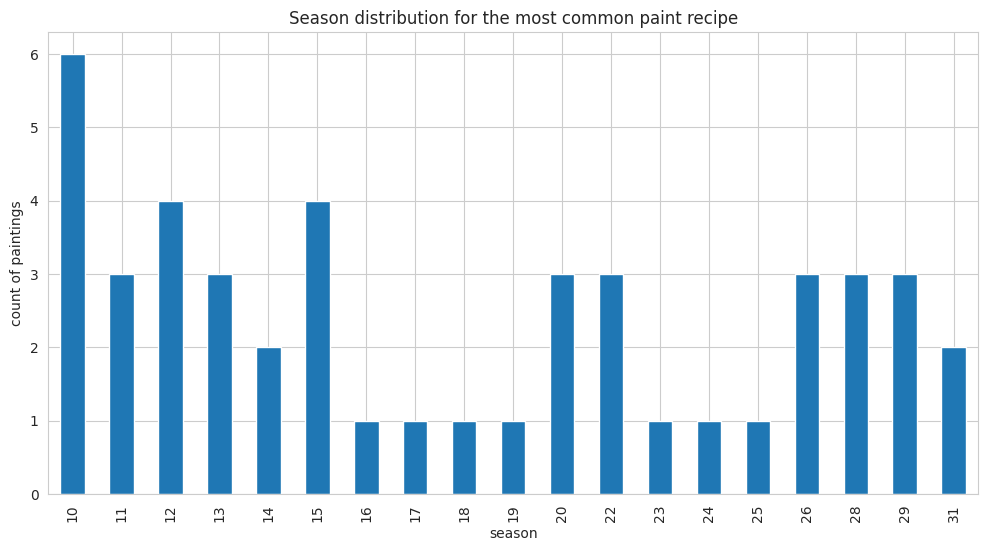

In [124]:
top_recipe_paintings = bob_ross.loc[mask].copy()

season_counts = top_recipe_paintings["season"].value_counts().sort_index()
display(season_counts)

plt.figure()
season_counts.plot(kind="bar")
plt.title("Season distribution for the most common paint recipe")
plt.xlabel("season")
plt.ylabel("count of paintings")
plt.show()

Using a near-duplicate threshold of 0.95, we identified 2,330 highly similar pairs, indicating substantial repetition or templating in palette composition. This tendency is also evident at the exact-recipe level, where the most frequent paint recipe appears in 46 paintings.

In conculsion, the results suggest that palette choices follow a small set of recurring templates with limited variation, creating clear opportunities to define interpretable groupings and boundaries within an otherwise consistent instructional series.

###EDA Summary

The dataset has 403 paintings and 18 binary paint indicators, and I did not find missing values or duplicate rows in the fields used for this analysis. The number of paints used per painting varies, so palette complexity is not the same across episodes. A few paints show up in almost every painting (for example, Titanium_White), which suggests a shared baseline palette, while other paints are much rarer and may help separate specialized palette groups.

##3.Integrated Analysis & Synergy

###Method 1: Hierarchical Clustering

####Palette Clustering: Baseline and Robustness

In [125]:
X_bool = X.to_numpy(dtype=bool)

# Compute Distance Matrices
D_jaccard = pairwise_distances(X_bool, metric="jaccard")
D_hamming = pairwise_distances(X_bool, metric="hamming")

print(f"Jaccard distance range: [{D_jaccard.min():.3f}, {D_jaccard.max():.3f}]")
print(f"Hamming distance range: [{D_hamming.min():.3f}, {D_hamming.max():.3f}]")

Jaccard distance range: [0.000, 1.000]
Hamming distance range: [0.000, 0.778]


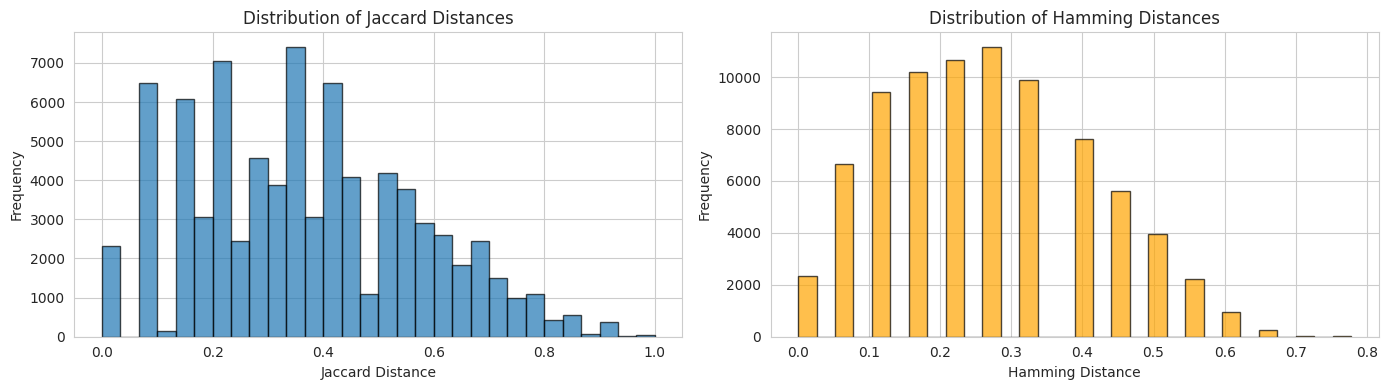

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

mask = np.triu(np.ones_like(D_jaccard, dtype=bool), k=1)
jaccard_vals = D_jaccard[mask]
hamming_vals = D_hamming[mask]

axes[0].hist(jaccard_vals, bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution of Jaccard Distances")
axes[0].set_xlabel("Jaccard Distance")
axes[0].set_ylabel("Frequency")

axes[1].hist(hamming_vals, bins=30, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Distribution of Hamming Distances")
axes[1].set_xlabel("Hamming Distance")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The Jaccard distances are more spread out, which means they can better distinguish differences between paintings whem we think of palettes as sets of used colors. In contrast, Hamming distances are more compressed because they cont share aabsences, making many paintings appear more similar than they actually are.

In [127]:
Z = linkage(X_paint_bool, method="average", metric="jaccard")

print("Linkage matrix shape:", Z.shape)

Linkage matrix shape: (402, 4)


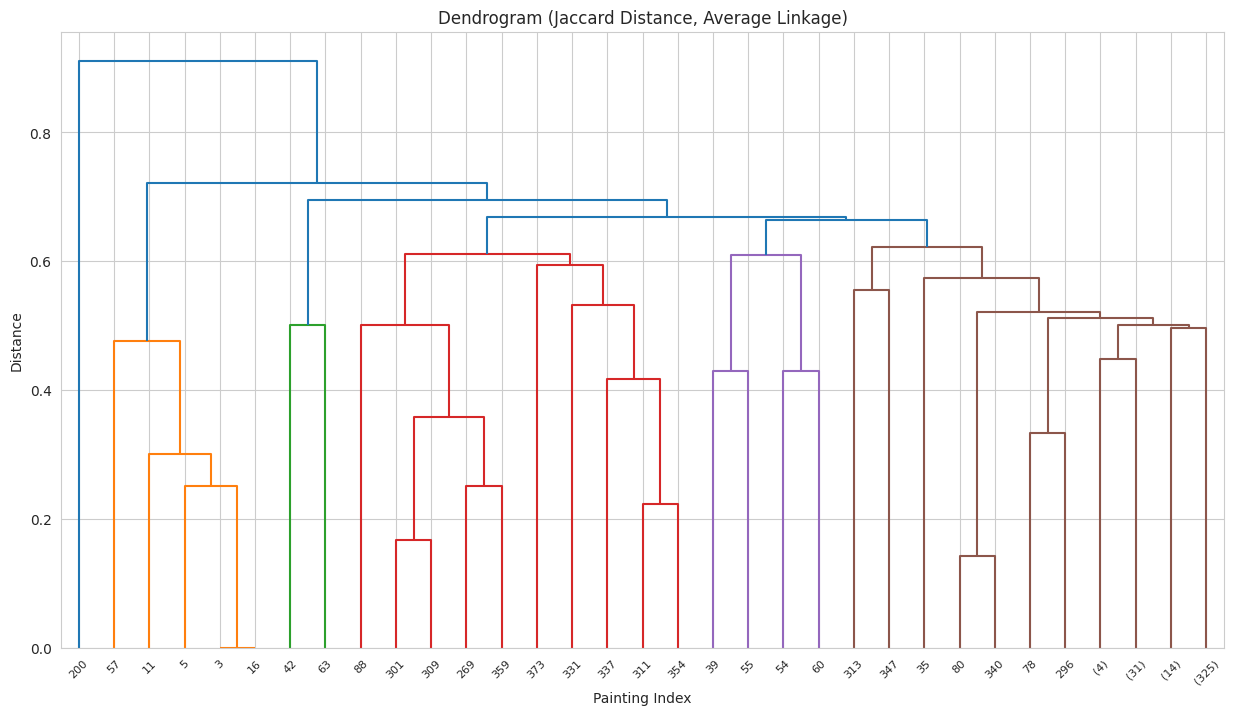

In [128]:
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='level', p=10)
plt.title("Dendrogram (Jaccard Distance, Average Linkage)")
plt.xlabel("Painting Index")
plt.ylabel("Distance")
plt.show()

In [129]:
n_clusters = 5

bob_ross["cluster_labels"] = fcluster(Z, n_clusters, criterion="maxclust").astype(str)


In [130]:
bob_ross["cluster_labels"].value_counts()

,count
cluster_labels,
4,385
3,10
1,5
2,2
5,1


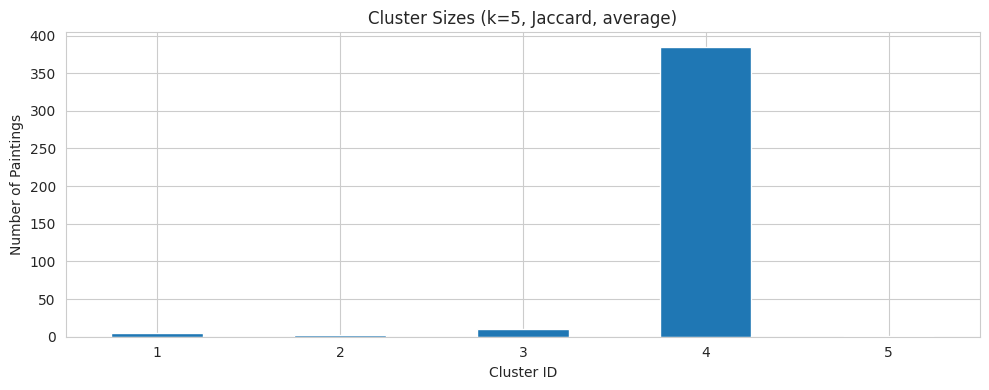

In [131]:
plt.figure(figsize=(10, 4))
bob_ross['cluster_labels'].value_counts().sort_index().plot(kind='bar')
plt.title(f"Cluster Sizes (k={n_clusters}, Jaccard, average)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Paintings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [132]:
one_rate = X.astype(int).values.mean()
print(f"Overall 1-rate: {one_rate:.3f} | 0-rate: {1-one_rate:.3f}")

Overall 1-rate: 0.589 | 0-rate: 0.411


Although paint usage is binary, there are many shared absences across paintings; Hamming counts these 0–0 matches and can compress distances, while Jaccard focuses on shared presences.

In [133]:
cluster_sizes = bob_ross['cluster_labels'].value_counts().sort_index()
largest_cluster_pct = cluster_sizes.max() / len(bob_ross) * 100

print("Cluster Balance Analysis:")
print(f"  Largest cluster: {cluster_sizes.max()} paintings ({largest_cluster_pct:.1f}%)")
print(f"  Smallest cluster: {cluster_sizes.min()} paintings ({cluster_sizes.min()/len(bob_ross)*100:.1f}%)")
print(f"  Imbalance ratio: {cluster_sizes.max() / cluster_sizes.min():.1f}:1")


Cluster Balance Analysis:
  Largest cluster: 385 paintings (95.5%)
  Smallest cluster: 1 paintings (0.2%)
  Imbalance ratio: 385.0:1


In [134]:
df_cluster = X.copy()
df_cluster["cluster_labels"] = bob_ross["cluster_labels"].values
display(df_cluster.head())

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,cluster_labels
0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
2,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1
4,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4


In [135]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()
cluster_sizes = bob_ross["cluster_labels"].value_counts()
dominant = cluster_sizes.idxmax()

baseline_rate = cluster_paint_rates.loc[dominant]
eps = 1e-9

lift_vs_baseline = cluster_paint_rates.div(baseline_rate + eps, axis=1)

top_n = 8
for cl in cluster_paint_rates.index:
    if cl == dominant:
        continue
    print(f"\nCluster {cl} vs baseline {dominant}: most over-represented paints")
    top = lift_vs_baseline.loc[cl].sort_values(ascending=False).head(top_n)
    display(pd.DataFrame({
        "lift_vs_baseline": top,
        "baseline_rate": baseline_rate.loc[top.index],
        "cluster_rate": cluster_paint_rates.loc[cl, top.index],
    }))


Cluster 1 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Liquid_Black,5.923077,0.033766,0.2
Prussian_Blue,1.558704,0.641558,1.0
Van_Dyke_Brown,1.054795,0.948052,1.0
Titanium_White,1.002604,0.997403,1.0
Black_Gesso,0.819149,0.244156,0.2
Alizarin_Crimson,0.413978,0.966234,0.4
Indian_Yellow,0.267361,0.748052,0.2
Bright_Red,0.000000,0.825974,0.0



Cluster 2 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Burnt_Umber,7.264151,0.137662,1.0
Black_Gesso,2.047872,0.244156,0.5
Prussian_Blue,1.558704,0.641558,1.0
Bright_Red,1.210692,0.825974,1.0
Titanium_White,1.002604,0.997403,1.0
Indian_Yellow,0.668403,0.748052,0.5
Midnight_Black,0.625000,0.800000,0.5
Cadmium_Yellow,0.559593,0.893506,0.5



Cluster 3 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Liquid_Clear,2.406250,0.124675,0.3
Black_Gesso,2.047872,0.244156,0.5
Prussian_Blue,1.402834,0.641558,0.9
Midnight_Black,1.000000,0.800000,0.8
Titanium_White,0.902344,0.997403,0.9
Phthalo_Blue,0.728707,0.823377,0.6
Sap_Green,0.639535,0.781818,0.5
Alizarin_Crimson,0.620968,0.966234,0.6



Cluster 5 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Van_Dyke_Brown,1.054795,0.948052,1.0
Black_Gesso,0.000000,0.244156,0.0
Bright_Red,0.000000,0.825974,0.0
Burnt_Umber,0.000000,0.137662,0.0
Dark_Sienna,0.000000,0.753247,0.0
Cadmium_Yellow,0.000000,0.893506,0.0
Indian_Yellow,0.000000,0.748052,0.0
Liquid_Black,0.000000,0.033766,0.0


Since one cluster contains almost all paintings, we treat it as the baseline palette rather than an “archetype.” We then compare the other clusters to this baseline. For each paint, we compute a simple ratio: cluster usage rate divided by baseline usage rate. Ratios above 1 highlight paints that are unusually common in a small cluster.

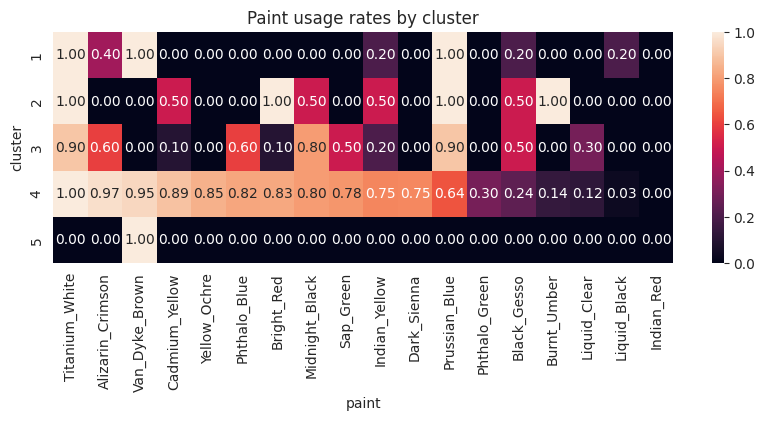

In [136]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()

top_paints = bob_ross[paint_cols].mean().sort_values(ascending=False).index
hm = cluster_paint_rates[top_paints]

plt.figure(figsize=(10,3))
sns.heatmap(hm, annot=True, fmt=".2f")
plt.title("Paint usage rates by cluster")
plt.xlabel("paint")
plt.ylabel("cluster")
plt.show()

Clustering with distance threshold instead of maxclust

In [137]:
cluster_threshold = [0.20, 0.40, 0.60, 0.85]
result = []
for t in cluster_threshold:
    labels =fcluster(Z, t=t, criterion="distance")
    cluster_sizes = pd.Series(labels).value_counts()
    print(f"\nCluster sizes for threshold={t}:\n{cluster_sizes}")

    n_clusters = len(np.unique(labels))
    largest_pct = cluster_sizes.max() / len(labels)
    smallest_pct = cluster_sizes.min() / len(labels)
    imbalance_ratio = cluster_sizes.max() / cluster_sizes.min()

    result.append({
        "threshold": t,
        "n_clusters": n_clusters,
        "largest_cluster_pct": largest_pct,
        "smallest_cluster_pct": smallest_pct,
        "imbalance_ratio": imbalance_ratio
    })

result_df = pd.DataFrame(result)
display(result_df)


Cluster sizes for threshold=0.2:
70    193
49     43
66     23
39     10
29      9
     ... 
21      1
12      1
9       1
15      1
54      1
Name: count, Length: 74, dtype: int64

Cluster sizes for threshold=0.4:
25    320
20     25
22     14
21      6
19      4
5       4
1       4
24      3
18      2
17      2
23      2
7       2
14      1
2       1
12      1
13      1
3       1
11      1
26      1
4       1
6       1
27      1
15      1
9       1
8       1
16      1
10      1
Name: count, dtype: int64

Cluster sizes for threshold=0.6:
8    379
1      5
3      5
4      5
5      2
6      2
2      2
7      2
9      1
Name: count, dtype: int64

Cluster sizes for threshold=0.85:
1    402
2      1
Name: count, dtype: int64


,threshold,n_clusters,largest_cluster_pct,smallest_cluster_pct,imbalance_ratio
0,0.20,74,0.478908,0.002481,193.0
1,0.40,27,0.794045,0.002481,320.0
2,0.60,9,0.940447,0.002481,379.0
3,0.85,2,0.997519,0.002481,402.0


The clustering analysis with different Jaccard distance thresholds shows a consistent pattern in Bob Ross's painting palettes. At a low threshold, it shows a high number of clusters with a relatively small largest cluster suggests significant variety in specific paint combinations. As the threshold increases, the number of clusters drastically decreases, with one dominant cluster obtaining a larger percentage of paintings. At a very high threshold, nearly all paintings merge into a single large cluster, with an extremely high imbalance ratio. This refeinforces our findings that Bob Ross predominantly used a highly consistent core palette across his body of work, with only a few variants demostrating distinct paint choices.

Since low threshold make the most seperations, so I am interested to explore:

In [138]:
labels_temp = fcluster(Z, t=0.20, criterion="distance")

temp_df_for_lowest_cluster = bob_ross.copy()
temp_df_for_lowest_cluster["cluster_labels"] = labels_temp

cluster_paint_lowest = temp_df_for_lowest_cluster.groupby("cluster_labels")[paint_cols].mean()

print("Average paint usage rates per cluster (threshold = 0.20):")
display(cluster_paint_lowest)

Average paint usage rates per cluster (threshold = 0.20):


,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
cluster_labels,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,0.000000
2,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,1.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,1.000000
5,1.000000,1.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.259067,0.968912,0.0,1.0,1.0,0.0,1.0,0.046632,0.119171,0.994819,0.870466,0.259067,0.715026,1.0,1.0,1.0,1.0,0.989637
71,0.000000,1.000000,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000
72,0.000000,1.000000,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,1.000000


At threshold of 0.20, the clustering produces 74 small groups, each with a distinct paint usage pattern. Many of these smaller clusters show very specific color choices, with some paints used in 0% or 100% of the paintings within that group. This shows that while a dominant palette exists, there are also several niche and highly specialized color combinations that represent distinct stylistic variations.

Overall, we retain both clustering views because they answer different levels of the same question about Bob Ross's palette structure. The k=5 result captures the macro pattern that one much bigger cluster shows that most paintings rely on a consistent core “standard palette”. In contrast, the distance threshold t = 0.20 produces many small clusters that reveal micro-level variations. These are specialized color combinations that act as deviations within that broader palette, instead of just separate styles.

####Dominant share vs threshold (robustness check)

,threshold,n_clusters,largest_cluster_pct,dominant_share_pct
0,0.20,74,0.478908,47.9
1,0.40,27,0.794045,79.4
2,0.60,9,0.940447,94.0
3,0.85,2,0.997519,99.8


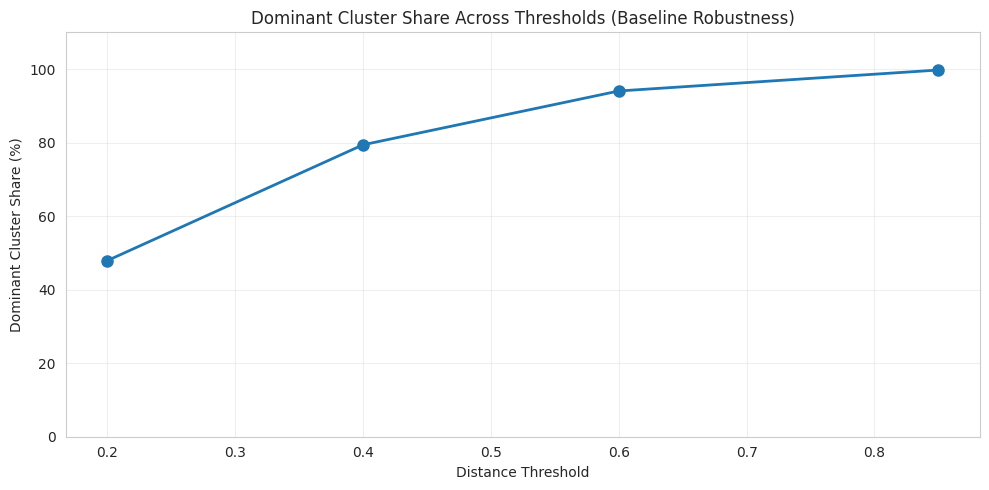

In [139]:
# Dominant cluster share vs threshold
display(result_df[["threshold", "n_clusters", "largest_cluster_pct"]].assign(dominant_share_pct=(result_df["largest_cluster_pct"] * 100).round(1)))

plt.figure(figsize=(10, 5))
plt.plot(result_df["threshold"], result_df["largest_cluster_pct"] * 100, marker="o", linewidth=2, markersize=8)
plt.xlabel("Distance Threshold")
plt.ylabel("Dominant Cluster Share (%)")
plt.title("Dominant Cluster Share Across Thresholds (Baseline Robustness)")
plt.grid(True, alpha=0.3)
plt.ylim([0, 110])
plt.tight_layout()
plt.show()

The dominant cluster remains large across thresholds, and confirming the 'one dominant palette' pattern is robust to cut choice.

####External Validation

#####Cluster vs season, episode and title themes
- Do different Palettes archetypes correspond to different themes or periods
- Check whether palette clusters line up with season or episode, and with title-based themes.


In [140]:
# season
cluster_season = pd.crosstab(bob_ross["cluster_labels"], bob_ross["season"])
print("Season & Cluster Table:")
display(cluster_season)

Season & Cluster Table:


season,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
cluster_labels,,,,,,,,,,,,,,,,,,,,,
1,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,3,0,2,0,2,1,0,0
4,10,12,13,12,11,13,12,13,13,13,...,13,13,10,13,11,13,11,12,13,13
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
# episode
print("Episode & Cluster Table:")
cluster_episode = pd.crosstab(bob_ross["cluster_labels"], bob_ross["episode"])
display(cluster_episode)

Episode & Cluster Table:


episode,1,2,3,4,5,6,7,8,9,10,11,12,13
cluster_labels,,,,,,,,,,,,,
1,0,0,0,2,0,2,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,0,1,1,0,0,1,0,1,2,2,0,2
4,31,31,30,27,31,28,30,31,30,29,29,29,29
5,0,0,0,0,0,1,0,0,0,0,0,0,0


In [142]:
# Assign title theme per painting
keyword_groups = {
    "landscape": {"mountain", "valley", "meadow", "forest", "woods"},
    "water": {"lake", "river", "stream", "waterfall", "falls"},
    "season_time": {"winter", "autumn", "day", "sunset"},
    "objects_view": {"cabin", "barn", "view", "oval"},
}

def get_theme(title):
    words = set(re.sub(r"[^a-z ]", "", str(title).lower()).split())
    for theme, kws in keyword_groups.items():
        if kws & words:
            return theme
    return "other"

bob_ross["title_theme"] = bob_ross["painting_title"].apply(get_theme)
cluster_theme = pd.crosstab(bob_ross["cluster_labels"], bob_ross["title_theme"])
print("Title theme & Cluster Table:")
display(cluster_theme)

Title theme & Cluster Table:


title_theme,landscape,objects_view,other,season_time,water
cluster_labels,,,,,
1,0,0,3,2,0
2,0,0,1,1,0
3,0,1,4,4,1
4,79,30,180,62,34
5,0,0,1,0,0


From these three crosstab, it can be known that the vast majority of Palettes (Cluster 4) neither correspond to a specific period (season/episode) nor to a specific title theme. Due to the small sample size of a few small Palettes, it is impossible to draw the conclusion that "different Archetypes clearly correspond to different themes or periods", and only their distribution on season/episode/title theme can be described.

Row-normalized crosstabs

In [143]:
cluster_season_rowpct = cluster_season.div(cluster_season.sum(axis=1), axis=0) * 100
print("Cluster & Season")
display(cluster_season_rowpct.round(1))

cluster_episode_rowpct = cluster_episode.div(cluster_episode.sum(axis=1), axis=0) * 100
print("\nCluster & Episode")
display(cluster_episode_rowpct.iloc[:, :5].round(1))

Cluster & Season


season,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
cluster_labels,,,,,,,,,,,,,,,,,,,,,
1,60.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,20.0,0.0,20.0,10.0,0.0,0.0
4,2.6,3.1,3.4,3.1,2.9,3.4,3.1,3.4,3.4,3.4,...,3.4,3.4,2.6,3.4,2.9,3.4,2.9,3.1,3.4,3.4
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Cluster & Episode


episode,1,2,3,4,5
cluster_labels,,,,,
1,0.0,0.0,0.0,40.0,0.0
2,0.0,0.0,0.0,50.0,0.0
3,0.0,0.0,10.0,10.0,0.0
4,8.1,8.1,7.8,7.0,8.1
5,0.0,0.0,0.0,0.0,0.0


The output shows that if a small cluster has high % in a specific season/episode that archetype may correspond to that period. Dominant cluster ~95%+ in every row = not period-specific.

#####Linkage comparison

In [144]:
# Average
Z_avg = linkage(X_paint_bool, method="average", metric="jaccard")
labels_avg = fcluster(Z_avg, 5, criterion="maxclust")
pd.Series(labels_avg).value_counts().sort_index()

,count
1,5
2,2
3,10
4,385
5,1


In [145]:
# Complete
Z_complete = linkage(X_paint_bool, method="complete", metric="jaccard")
labels_complete = fcluster(Z_complete, 5, criterion="maxclust")
pd.Series(labels_complete).value_counts().sort_index()

,count
1,331
2,15
3,44
4,13


In [146]:
# Ward
Z_ward = linkage(X_paint_bool.astype(float), method="ward")
labels_ward = fcluster(Z_ward, 5, criterion="maxclust")
pd.Series(labels_ward).value_counts().sort_index()

,count
1,155
2,50
3,66
4,58
5,74


In [147]:
# Single
Z_single = linkage(X_paint_bool.astype(float), method="single")
labels_single = fcluster(Z_single, 5, criterion="maxclust")
pd.Series(labels_single).value_counts().sort_index()

,count
1,399
2,1
3,1
4,1
5,1


In [148]:
# Comparing together
cluster_sizes = pd.DataFrame({
    "average": pd.Series(labels_avg).value_counts().sort_index(),
    "complete": pd.Series(labels_complete).value_counts().sort_index(),
    "ward": pd.Series(labels_ward).value_counts().sort_index(),
    "single": pd.Series(labels_single).value_counts().sort_index()
})
cluster_sizes

,average,complete,ward,single
1,5,331.0,155,399
2,2,15.0,50,1
3,10,44.0,66,1
4,385,13.0,58,1
5,1,NaN,74,1


Changing only linkage yields substantially different size distributions, so the partition is sensitive to linkage choice. Average+Jaccard reproduces the strongest baseline–deviation structure and aligns with the set-based interpretation of paint usage, so I retain it as the primary view while reporting linkage sensitivity as a robustness finding.

###Method 2: Association Rule

Remove near-constant items to improve rule interpretability

In [149]:
X_bool_df = X.astype(bool)

df_rules = X_bool_df.copy()
df_rules["cluster_labels"] = bob_ross["cluster_labels"].values

display(df_rules.head())

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,cluster_labels
0,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
1,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
2,True,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,1
4,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,4


In [150]:
global_usage = X_paint_df.mean().sort_values(ascending=False)
display(global_usage.head(12))

TRIVIAL_THRESH = 0.95
trivial_paints = set(global_usage[global_usage >= TRIVIAL_THRESH].index)

print("Trivial paints (global usage >= 0.95):")
print(sorted(list(trivial_paints)))

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


Trivial paints (global usage >= 0.95):
['Titanium_White']


Titanium_White (usage ≈ 0.992) is a trivial item that appears in almost all paintings, so it provides little segmentation signal and can dominate rules. The dominant-cluster pattern is better explained by the broader baseline template documented earlier (high Jaccard similarity and repeated exact recipes), rather than a code issue.

In [151]:
def mine_rules(df_bool, min_support=0.15, min_conf=0.6, min_lift=1.05, max_len=3):
    itemsets = apriori(df_bool, min_support=min_support, use_colnames=True, max_len=max_len)
    if itemsets.empty:
        return pd.DataFrame()
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf)
    if rules.empty:
        return pd.DataFrame()
    rules = rules[rules["lift"] >= min_lift].copy()
    if rules.empty:
        return pd.DataFrame()
    rules["antecedents"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(s)))
    rules["consequents"] = rules["consequents"].apply(lambda s: ", ".join(sorted(s)))
    return rules[["antecedents","consequents","support","confidence","lift"]].sort_values(
        ["lift","confidence","support"], ascending=False
    ).reset_index(drop=True)

####Global Baseline Rules

use Apriori to find frequent itemsets and then generate rules.

In [152]:
# Global baseline rules
X_global = X_bool_df.drop(columns=list(trivial_paints), errors="ignore").copy()

global_min_sup = 0.10
global_min_conf = 0.60
global_min_lift = 1.30
MAX_LEN = 3

rules_global = mine_rules(
    X_global.astype(bool),
    min_support=global_min_sup,
    min_conf=global_min_conf,
    min_lift=global_min_lift,
    max_len=MAX_LEN
)

print("\n=== Global rules (after removing trivial paints) ===")
display(rules_global.head(15))


=== Global rules (after removing trivial paints) ===


,antecedents,consequents,support,confidence,lift
0,Phthalo_Green,"Prussian_Blue, Sap_Green",0.205955,0.715517,1.393012
1,"Liquid_Clear, Van_Dyke_Brown",Dark_Sienna,0.106700,0.977273,1.358072
2,Dark_Sienna,"Midnight_Black, Van_Dyke_Brown",0.707196,0.982759,1.356342
3,"Midnight_Black, Van_Dyke_Brown",Dark_Sienna,0.707196,0.976027,1.356342
4,Phthalo_Green,"Phthalo_Blue, Prussian_Blue",0.191067,0.663793,1.344264
5,Phthalo_Green,"Bright_Red, Prussian_Blue",0.200993,0.698276,1.340025
6,Phthalo_Green,"Cadmium_Yellow, Prussian_Blue",0.210918,0.732759,1.318311
7,"Indian_Yellow, Midnight_Black",Dark_Sienna,0.555831,0.941176,1.307911
8,Dark_Sienna,"Indian_Yellow, Midnight_Black",0.555831,0.772414,1.307911
9,"Midnight_Black, Yellow_Ochre",Dark_Sienna,0.627792,0.940520,1.306999


The global baseline is set to compare whether the rules within the cluster are just globally common structures or cluster-specific. At the same time, Titanium_White global usage≈0.992, which occurs almost always, dominates the rules and reduces interpretability. Therefore, it is removed first to highlight the more informative co-occurrence relationship.

####rule parameter sensitivity
- Try a few min_support values for global rules and see how many rules we get.

For the global sensitivity check, I set a looser lift filter (min_lift = 1.05) because the goal is to see how the volume of candidate rules changes as min_support increases, not to claim that every rule is strongly informative. Using 1.05 keeps mildly positive associations in the pool, which makes the parameter sensitivity pattern easier to observe.

In [153]:
df_glob = df_rules.drop(columns=["cluster_labels"], errors="ignore").copy()
df_glob = df_glob.drop(columns=list(trivial_paints), errors="ignore")
for sup in [0.03, 0.05, 0.08, 0.10, 0.15]:
    r = mine_rules(df_glob.astype(bool), min_support=sup, min_conf=0.6, min_lift=1.05)
    print(f"min_support={sup}: {len(r)} rules")

min_support=0.03: 948 rules
min_support=0.05: 940 rules
min_support=0.08: 889 rules
min_support=0.1: 834 rules
min_support=0.15: 734 rules


Varying the minimum support threshold shows that rule counts decrease as support increases. This confirms that Apriori is sensitive to parameter settings. However, the strongest co‑usage patterns remain present across thresholds, indicating that the core palette relationships are robust while weaker patterns are parameter‑dependent.

####With-cluster Rules

For within-cluster interpretation, I use a stricter lift threshold (min_lift = 1.30) to focus on rules that are meaningfully stronger than independence and more likely to reflect a distinctive co-usage signature, especially given the small n of non-dominant clusters. This stricter filter improves interpretability and reduces noisy or marginal associations.

In [154]:
# Within-cluster rules
MIN_CLUSTER_N = 10
MIN_CONF = 0.60
MIN_LIFT = 1.30
MAX_LEN = 3

cluster_rules = {}

for cl in sorted(df_rules["cluster_labels"].unique()):
    sub = df_rules[df_rules["cluster_labels"] == cl].drop(columns=["cluster_labels"]).copy()
    n_cl = sub.shape[0]

    print(f"\n Cluster {cl} | n={n_cl} ")

    if n_cl < MIN_CLUSTER_N:
        print("Too small for stable rules -> treat as rare palette case (skip rule mining).")
        continue

    sub = sub.drop(columns=list(trivial_paints), errors="ignore")

    min_sup = max(3 / n_cl, 0.10)
    print(f"min_support={min_sup:.3f}, min_conf={MIN_CONF:.2f}, min_lift={MIN_LIFT:.2f}")

    rules_cl = mine_rules(
        sub.astype(bool),
        min_support=min_sup,
        min_conf=MIN_CONF,
        min_lift=MIN_LIFT,
        max_len=MAX_LEN
    )

    if rules_cl.empty:
        print("No rules found under these thresholds.")
        continue

    display(rules_cl.head(12))
    cluster_rules[cl] = rules_cl


 Cluster 1 | n=5 
Too small for stable rules -> treat as rare palette case (skip rule mining).

 Cluster 2 | n=2 
Too small for stable rules -> treat as rare palette case (skip rule mining).

 Cluster 3 | n=10 
min_support=0.300, min_conf=0.60, min_lift=1.30


,antecedents,consequents,support,confidence,lift
0,Liquid_Clear,"Black_Gesso, Sap_Green",0.3,1.00,2.5
1,"Black_Gesso, Sap_Green",Liquid_Clear,0.3,0.75,2.5
2,Liquid_Clear,Black_Gesso,0.3,1.00,2.0
3,Liquid_Clear,Sap_Green,0.3,1.00,2.0
4,"Liquid_Clear, Prussian_Blue",Black_Gesso,0.3,1.00,2.0
5,Liquid_Clear,"Black_Gesso, Prussian_Blue",0.3,1.00,2.0
6,"Black_Gesso, Liquid_Clear",Sap_Green,0.3,1.00,2.0
7,"Liquid_Clear, Sap_Green",Black_Gesso,0.3,1.00,2.0
8,"Black_Gesso, Midnight_Black",Sap_Green,0.3,1.00,2.0
9,"Alizarin_Crimson, Black_Gesso",Sap_Green,0.3,1.00,2.0



 Cluster 4 | n=385 
min_support=0.100, min_conf=0.60, min_lift=1.30


,antecedents,consequents,support,confidence,lift
0,Phthalo_Green,"Prussian_Blue, Sap_Green",0.215584,0.715517,1.363733
1,Phthalo_Green,"Phthalo_Blue, Prussian_Blue",0.200000,0.663793,1.324147



 Cluster 5 | n=1 
Too small for stable rules -> treat as rare palette case (skip rule mining).


When n is very small, for example, less than 5. Rules can be driven by a very small number of samples and are unstable. So I set MIN_CLUSTER_N=10. If it is less than 10, rule mining is not performed, but described using cluster-level usage/lift profile.

In [155]:
def rule_key(df):
    a = df["antecedents"].astype(str).str.strip()
    c = df["consequents"].astype(str).str.strip()
    return list(zip(a, c))

global_keys = set(rule_key(rules_global)) if (rules_global is not None and not rules_global.empty) else set()

for cl, rules_cl in cluster_rules.items():
    if rules_cl is None or rules_cl.empty:
        continue

    r = rules_cl.copy()
    r["is_global_common"] = rule_key(rules_cl)
    r["is_global_common"] = pd.Series(r["is_global_common"]).isin(global_keys).to_numpy()

    n_all = len(r)
    n_common = int(r["is_global_common"].sum())
    n_only = n_all - n_common

    print(f"\nCluster {cl}: {n_all} rules ({n_common} also appear globally), cluster-only = {n_only}")

    sig = (r[~r["is_global_common"]].sort_values(["lift", "confidence", "support"], ascending=False)[["antecedents","consequents","support","confidence","lift"]].head(12))
    if not sig.empty:
        display(sig)



Cluster 3: 43 rules (0 also appear globally), cluster-only = 43


,antecedents,consequents,support,confidence,lift
0,Liquid_Clear,"Black_Gesso, Sap_Green",0.3,1.00,2.5
1,"Black_Gesso, Sap_Green",Liquid_Clear,0.3,0.75,2.5
2,Liquid_Clear,Black_Gesso,0.3,1.00,2.0
3,Liquid_Clear,Sap_Green,0.3,1.00,2.0
4,"Liquid_Clear, Prussian_Blue",Black_Gesso,0.3,1.00,2.0
5,Liquid_Clear,"Black_Gesso, Prussian_Blue",0.3,1.00,2.0
6,"Black_Gesso, Liquid_Clear",Sap_Green,0.3,1.00,2.0
7,"Liquid_Clear, Sap_Green",Black_Gesso,0.3,1.00,2.0
8,"Black_Gesso, Midnight_Black",Sap_Green,0.3,1.00,2.0
9,"Alizarin_Crimson, Black_Gesso",Sap_Green,0.3,1.00,2.0



Cluster 4: 2 rules (2 also appear globally), cluster-only = 0


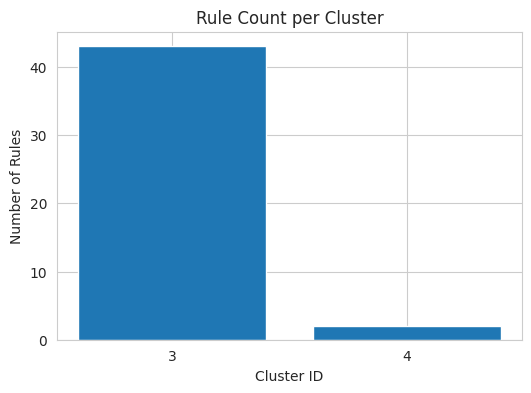

In [156]:
rule_counts = {cl: len(rules) for cl, rules in cluster_rules.items()}
plt.figure(figsize=(6,4))
plt.bar(rule_counts.keys(), rule_counts.values())
plt.xlabel("Cluster ID")
plt.ylabel("Number of Rules")
plt.title("Rule Count per Cluster")
plt.show()

Cluster 4 (n=385) yields only two high-lift rules under strict thresholds (min_lift=1.30), suggesting this large cluster mostly reflects the dataset’s common paint co-usage structure rather than a highly distinctive signature. In contrast, Cluster 3 (n=10) produces multiple high-lift, high-confidence rules centered on Liquid_Clear and Black_Gesso (support=0.30 = 3/10 paintings), indicating a more distinctive co-occurrence pattern that helps interpret this cluster as a rare palette archetype. Clusters with n < 10 are treated as rare/outlier cases because rules would be unstable and driven by very few paintings.

####Interpretable Palette Rules

#####Title-based clustering and comparison with palette clusters

Cluster paintings by title text

In [157]:
vectorizer = CountVectorizer(max_features=50, stop_words="english")
title_matrix = vectorizer.fit_transform(bob_ross["painting_title"].fillna(""))

Crosstab with palette cluster_labels

In [158]:
kmeans_title = KMeans(n_clusters=4, random_state=42)
bob_ross["title_cluster"] = kmeans_title.fit_predict(title_matrix)

title_vs_palette = pd.crosstab(bob_ross["cluster_labels"], bob_ross["title_cluster"])
title_vs_palette

title_cluster,0,1,2,3
cluster_labels,,,,
1,0,5,0,0
2,0,2,0,0
3,1,9,0,0
4,13,310,18,44
5,0,1,0,0


cosine similarity

In [159]:
cos_sim = np.round(cosine_similarity(title_matrix), 2)

cos_sim_df = pd.DataFrame(
    cos_sim,
    index=bob_ross.index,
    columns=bob_ross.index
)

cos_sim_df

,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,0.0,1.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,0.0,0.0,1.00,0.0,0.71,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0
4,0.0,0.0,0.0,0.00,1.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.71,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0
399,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
400,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0
401,0.0,0.0,0.0,0.71,0.0,1.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0


In [160]:
cos_sim_df.iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.00,0.0,0.71,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.71,0.0,1.00,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.5
7,0.0,0.0,0.0,0.00,0.0,0.00,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.00,0.0,0.00,0.5,0.0,0.0,1.0


I computed a 403×403 cosine similarity matrix CountVectorizer title vectors. Printing the full matrix is not interpretable. So, I use upper-triangle distribution.

In [161]:
upper = cos_sim[np.triu_indices_from(cos_sim, k=1)]
pd.Series(upper).describe()
(upper > 0).mean()

np.float64(0.039591126254583164)

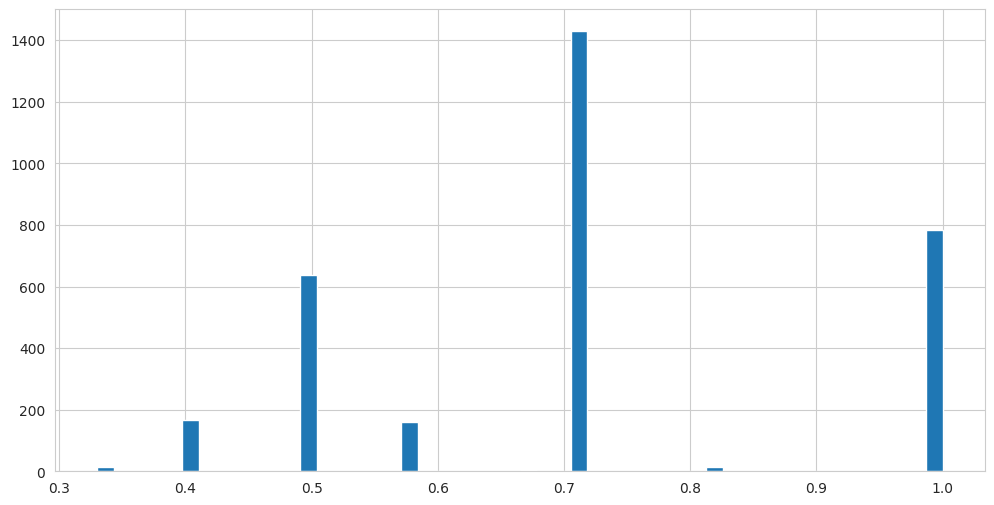

,0
count,3207.000000
mean,0.715460
std,0.188486
min,0.330000
25%,0.500000
50%,0.710000
75%,0.710000
max,1.000000


In [162]:
upper_non_zero = upper[upper > 0]

plt.hist(upper_non_zero, bins=50)
plt.show()

pd.Series(upper_non_zero).describe()

Title cohesion

In [163]:
def avg_pairwise_cosine(sim, idx):
    idx = np.array(idx)
    if len(idx) < 2:
        return np.nan
    sub = sim[np.ix_(idx, idx)]
    mask = ~np.eye(len(idx), dtype=bool)
    return sub[mask].mean()

rows = []
for c in sorted(bob_ross["cluster_labels"].unique()):
    idx = bob_ross.index[bob_ross["cluster_labels"] == c].to_numpy()
    rows.append({
        "palette_cluster": c,
        "n": len(idx),
        "title_cohesion_avg_cosine": avg_pairwise_cosine(cos_sim, idx)
    })

title_cohesion = pd.DataFrame(rows).sort_values("n", ascending=False)
title_cohesion

,palette_cluster,n,title_cohesion_avg_cosine
3,4,385,0.027457
2,3,10,0.196444
0,1,5,0.071000
1,2,2,0.000000
4,5,1,NaN


Title similarity is extremely sparse: only ~4% of title pairs have non-zero cosine similarity, indicating weak global thematic structure in titles. The dominant palette cluster (n=385) also shows very low title cohesion (avg cosine ≈ 0.03), while the 10-painting cluster has higher cohesion (≈0.20), suggesting that most rare palette deviations are not driven by distinct title themes, though a subset may align with more specific thematic language.